In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from scipy.stats import spearmanr, ttest_ind
import seaborn as sns
import matplotlib as mpl

font = {'family' : 'sans-serif',
        'size'   : 16}
mpl.rc('font', **font)
mpl.rc('lines', linewidth=2)
mpl.rcParams['axes.linewidth'] = 2
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['ytick.major.width'] = 2


def load_models(models, names):
    dfs = []
    for model, name in zip(models, names):
        summary_df = pd.read_csv(f'../results/{model}.csv')
        summary_df['model'] = name
        dfs.append(summary_df)
    summary_df = pd.concat(dfs)

    summary_df['frac_good_enzymes'] = summary_df['frac_good'] * summary_df['frac_enzymes']
    summary_df.rename(columns={'frac_good': 'Valid Proteins', 'frac_enzymes': 'Frac Enzymes', 'frac_good_enzymes': 'Valid Enzymes', 'frac_ec_correct': 'Correct EC', 'avg_max_id': 'Mean Max \nSeq Identity', 'frac_90clusters': "90% Clusters", 'frac_70clusters': "70% Clusters","average_prediction_similarity": "Similarity to Target EC", "similarity_to_train": "Similarity to Train", "frac_tax_correct": "Correct Tax", "tax_enrichment": "Tax Enrichment", "ec_enrichment": "EC Enrichment", "both_enrichment": "Both Enrichment", "frac_both_correct": "Both Correct"}, inplace=True)

    #rename splits
    mapping = {'train_common': 'Train Common ECs', 'train_rare': 'Train Rare ECs', 'test': 'Heldout ECs'}
    summary_df['split'] = summary_df['split'].map(mapping)

    return summary_df

In [3]:
models = [
          'ec-onehot-swissprot_20240819-231400/all_summary_ba11000_temp0.3',
          'ec-onehot-swissprot_20240819-231400/all_summary_ba21000_temp0.3',
          'ec-onehot-swissprot_20240819-231400/all_summary_ba42000_temp0.3',
          'ec-onehot-swissprot_20240819-231400/all_summary_ba63000_temp0.3','ec-onehot-swissprot-ff_20240822-163730/all_summary_ba11000_temp0.3',
          'ec-onehot-swissprot-ff_20240822-163730/all_summary_ba21000_temp0.3',
          'ec-onehot-swissprot-ff_20240822-163730/all_summary_ba42000_temp0.3',
          'ec-onehot-swissprot-ff_20240822-163730/all_summary_ba63000_temp0.3',
          'ec-onehot-uniref_20240820-021701/all_summary_ba11000_temp0.3',
          'ec-onehot-uniref_20240820-021701/all_summary_ba21000_temp0.3',
          'ec-onehot-uniref_20240820-021701/all_summary_ba42000_temp0.3',
          'ec-onehot-uniref_20240820-021701/all_summary_ba63000_temp0.3',
          ]

names = ['Swissprot', 'Swissprot', 'Swissprot', 'Swissprot', 'Swissprot-FF', 'Swissprot-FF', 'Swissprot-FF', 'Swissprot-FF', 'Uniref', 'Uniref', 'Uniref', 'Uniref']

summary_df = load_models(models, names)
batch_size = 144e3
summary_df['Tokens'] = summary_df['checkpoint'].str[2:].astype(int) * batch_size

summary_df = summary_df.rename(columns={'model': 'Model', 'split': 'Split'})
                            
train_summary_df = summary_df[summary_df['Split'].isin(['Train Common ECs', 'Train Rare ECs'])].reset_index(drop=True)
train_common_summary_df = summary_df[summary_df['Split'] == 'Train Common ECs']
train_rare_summary_df = summary_df[summary_df['Split'] == 'Train Rare ECs']
#hard_summary_df = summary_df[summary_df['split'].isin(['Train Rare ECs', 'Heldout ECs'])]

### for appendix, lineplot tracking various metrics over time
Note that ZymCTRL was trained for 60 billion tokens

* loss curves
* generation quality metrics 

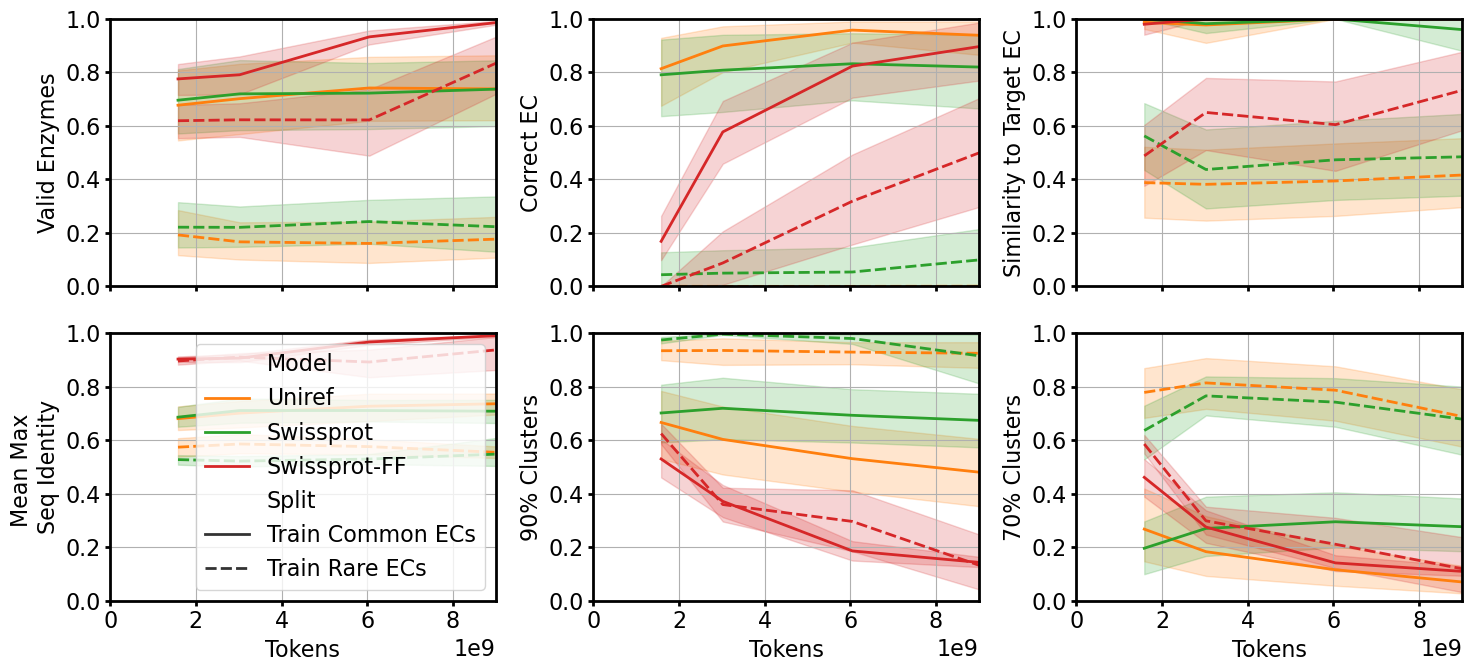

In [4]:
plt.figure(figsize=(15, 7))
i = 0
for column in ["Valid Enzymes", "Correct EC", "Similarity to Target EC", "Mean Max \nSeq Identity", "90% Clusters", "70% Clusters"]:
        i += 1
        plt.subplot(2, 3, i)
        legend = True if i == 4 else False

        sns.lineplot(data=train_summary_df, x='Tokens', y=column, hue='Model', style='Split', legend=legend, palette=sns.color_palette(['tab:orange', 'tab:green', 'tab:red']), hue_order=['Uniref', 'Swissprot', 'Swissprot-FF']) #palette=sns.color_palette(['tab:orange', 'tab:green', 'tab:red'])

        #move legend outside graph
        # if i == 5:
        #     plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        
        plt.ylim(0, 1)
        plt.xlim(0, 9e9)
        plt.grid(True)
        if i <= 3:
                plt.xlabel('')
                ax = plt.gca()
                ax.set_xticklabels([])

# plt.subplot(2, 3, 6)
# #make a legend and hide everything
# sns.lineplot(data=train_summary_df, x='Tokens', y=column, hue='Model', style='Split', legend=True) #palette=sns.color_palette(['tab:orange', 'tab:green', 'tab:red'])
# plt.xlim(0, 1)
# plt.ylim(0, 1)
# plt.ylabel('')
# plt.xlabel('')
# plt.yticks([])
# plt.xticks([])
# #hide all axes from this subplot
# plt.gca().spines[['left', 'right', 'bottom', 'top']].set_visible(False)

plt.tight_layout()
plt.savefig('figures/metrics_lineplot.svg')

In [340]:
# plt.figure(figsize=(12, 7))
# i = 0
# for columns in [["Valid Enzymes", "Correct EC", "Similarity to Target EC"], ["Mean Max \nSeq Identity", "90% Clusters"]]:
#     for subset_summary_df, title in zip([train_common_summary_df, train_rare_summary_df], ['Train Common ECs', 'Train Rare ECs']):
#         i += 1
#         plt.subplot(2, 2, i)

#         df = pd.DataFrame(columns=['value', 'label', 'model', 'Tokens'])

#         for j, row in subset_summary_df.iterrows():
#             for col in columns:
#                 df.loc[len(df.index)] = [row[col], col, row['model'], row['Tokens']]

#         sns.lineplot(data=df, x='Tokens', y='value', hue='label', style='model')

#         sns.lineplot(data=df, x='Tokens', y='value', hue='label', style='model')
#         #move legend outside graph
#         if i == 2 or i == 4:
#             plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#         else:
#             plt.legend().remove()
        
#         plt.ylim(0, 1)
#         plt.ylabel('')
#         plt.xlim(0, 6e9)
#         if i == 1 or i == 2:
#             plt.title(title)
#             plt.xlabel('')
#         plt.grid(True)

# plt.tight_layout()

### Make figure on common ECs

process perplexities

In [5]:
#load perplexities
models = ['ec-onehot-swissprot_20240819-231400/perplexity_ba11000',
          'ec-onehot-uniref_20240820-021701/perplexity_ba11000',
          'ec-drfp-swissprot_20240820-004555/perplexity_ba11000',
          'ec-creep-swissprot_20240820-004559/perplexity_ba11000',]
names = ['Swissprot-OH-1.5B', 'Uniref-OH-1.5B', 'Swissprot-DRFP-1.5B', 'Swissprot-CREEP-1.5B']

dfs = []
# perplexity_df = load_models(models, names)
#sns.violinplot(data=df, x='split', y='perplexity', cut=0, density_norm="width") #hue='model'

for model, name in zip(models, names):
    perplexity_df = pd.read_csv(f'../results/{model}.csv')
    perplexity_df['model'] = name
    dfs.append(perplexity_df)

perplexity_df = pd.concat(dfs)
mapping = {'train_common': 'Train\nCommon ECs', 'train_rare': 'Train\nRare ECs', 'test': 'Heldout ECs', 'val70': 'Heldout 70%', 'val90': 'Heldout 90%'}
perplexity_df['split'] = perplexity_df['split'].map(mapping)
perplexity_df.reset_index(drop=True, inplace=True)

first_perplexity_df = perplexity_df[perplexity_df['split'].isin(['Train\nCommon ECs', 'Heldout 70%', 'Heldout 90%']) & perplexity_df['model'].isin(['Swissprot-OH-1.5B'])] #'Uniref-OH-1.5B'
second_perplexity_df = perplexity_df[perplexity_df['split'].isin(['Train\nCommon ECs', 'Train\nRare ECs', 'Heldout ECs']) & perplexity_df['model'].isin(['Swissprot-OH-1.5B', 'Swissprot-DRFP-1.5B', 'Swissprot-CREEP-1.5B'])]

In [6]:
models = ['ZymCTRL/all_summary_pretrained_temp0.3',
          'ec-onehot-uniref_20240820-021701/all_summary_ba63000_temp0.3',
          'ec-onehot-swissprot_20240819-231400/all_summary_ba11000_temp0.3',
          ] #'ec-onehot-swissprot_20240819-231400/all_summary_ba63000_temp0.3', 'ec-onehot-swissprot-ff_20240822-163730/all_summary_ba63000_temp0.3',

names = ['ZymCTRL', 'Uniref-9B', 'Swissprot-1.5B'] #'Swissprot-9B', 'Swissprot-FF-9B'
# models = models[:3]
# names = names[:3]

summary_df = load_models(models, names)
summary_df.rename(columns={'model': 'Model'}, inplace=True)
summary_df = summary_df.reset_index(drop=True)
train_common_summary_df = summary_df[summary_df['split'] == 'Train Common ECs']
train_common_summary_df

,Model,checkpoint,ec,tax,split,n_generated,frac_terminated,Valid Proteins,n_good,Frac Enzymes,...,Mean Max \nSeq Identity,70% Clusters,90% Clusters,generated_ECs,both_count,ec_count,tax_count,Similarity to Target EC,Similarity to Train,Valid Enzymes
0,ZymCTRL,pretrained,2.7.1.148,no-tax,Train Common ECs,900,1.000000,0.936667,843,1.000000,...,0.562125,0.752076,0.927639,"['2.7.1.148', '2.7.1.148', '2.7.1.148', '2.7.1...",NaN,514,NaN,1.0,1.0,0.936667
1,ZymCTRL,pretrained,2.7.13.3,no-tax,Train Common ECs,900,0.998889,0.218889,197,1.000000,...,0.477188,0.802030,0.928934,"['2.7.13.3', '2.7.13.3', '2.7.13.3', '2.7.13.3...",NaN,579,NaN,1.0,1.0,0.218889
2,ZymCTRL,pretrained,6.1.1.15,no-tax,Train Common ECs,900,1.000000,0.897778,808,1.000000,...,0.682418,0.594059,0.835396,"['6.1.1.15', '6.1.1.15', '6.1.1.15', '6.1.1.15...",NaN,525,NaN,1.0,1.0,0.897778
3,ZymCTRL,pretrained,1.2.1.70,no-tax,Train Common ECs,900,1.000000,0.935556,842,1.000000,...,0.623837,0.668646,0.815914,"['1.2.1.70', '1.2.1.70', '1.2.1.70', '1.2.1.70...",NaN,561,NaN,1.0,1.0,0.935556
4,ZymCTRL,pretrained,2.5.1.75,no-tax,Train Common ECs,900,1.000000,0.966667,870,1.000000,...,0.589436,0.726437,0.890805,"['2.5.1.75', '2.5.1.75', '2.5.1.75', '2.5.1.75...",NaN,648,NaN,1.0,1.0,0.966667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,Swissprot-1.5B,ba11000,2.7.7.6,no-tax,Train Common ECs,900,0.544444,0.324444,292,0.808219,...,0.716764,0.347458,0.584746,"['2.7.7.6', '2.7.7.6', '2.7.7.6', '2.7.7.6', '...",NaN,894,NaN,1.0,1.0,0.262222
140,Swissprot-1.5B,ba11000,3.1.1.29,no-tax,Train Common ECs,900,0.918889,0.915556,824,1.000000,...,0.657504,0.015777,0.798544,"['3.1.1.29', '3.1.1.29', '3.1.1.29', '3.1.1.29...",NaN,553,NaN,1.0,1.0,0.915556
141,Swissprot-1.5B,ba11000,6.1.1.21,no-tax,Train Common ECs,900,0.925556,0.820000,738,0.981030,...,0.724060,0.080110,0.682320,"['6.1.1.21', '6.1.1.21', '6.1.1.21', '6.1.1.21...",NaN,516,NaN,1.0,1.0,0.804444
142,Swissprot-1.5B,ba11000,2.7.1.33,no-tax,Train Common ECs,900,0.721111,0.712222,641,0.998440,...,0.660289,0.065625,0.603125,"['2.7.1.33', '2.7.1.33', '2.7.1.33', '2.7.1.33...",NaN,543,NaN,1.0,1.0,0.711111


In [10]:
#make a table showing the computational cost of training the model
#swissprot took 60.4 hours for full training
#uniref took 63.2 hours for full training (ba67000ish)
compute_df = pd.DataFrame(columns=['Model', 'Tokens', 'GPU Hours'])
for i, model in enumerate(names):
    dict = {"tokens": [50e9, 9e9, 1.5e9], "gpu_hours": [15e3, 63.2* 63/67 * 4, 60.4 * 11/67 * 4]}
    compute_df.loc[len(compute_df.index)] = [model, dict["tokens"][i], dict["gpu_hours"][i]]
compute_df

,Model,Tokens,GPU Hours
0,ZymCTRL,5.000000e+10,15000.000000
1,Uniref-9B,9.000000e+09,237.707463
2,Swissprot-1.5B,1.500000e+09,39.665672


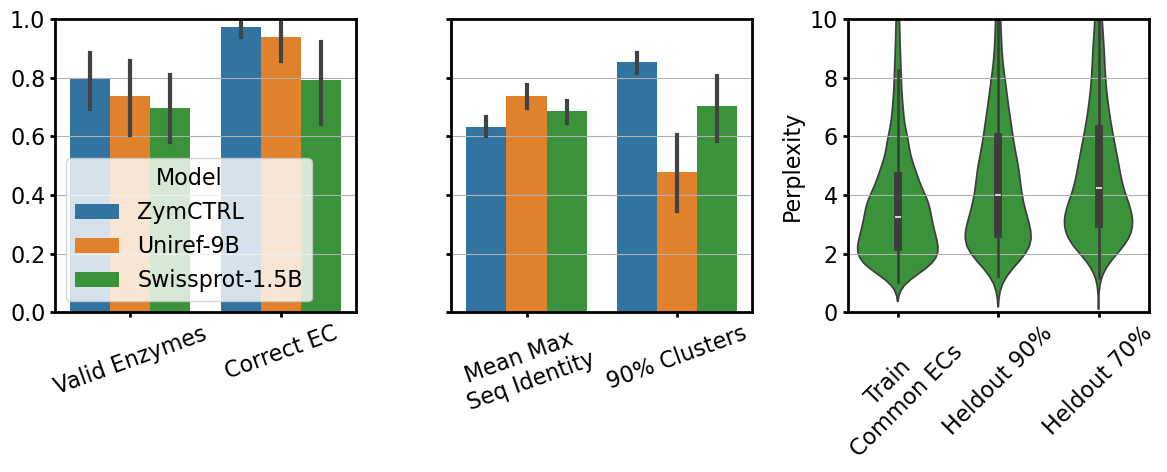

In [15]:
plt.figure(figsize=(12, 5)) #a bit narrow for full width
i = 0

for columns in [["Valid Enzymes", "Correct EC"], ["Mean Max \nSeq Identity", "90% Clusters"]]:
    i += 1
    plt.subplot(1, 3, i)
    legend = True if i == 1 else False

    df = pd.DataFrame(columns=['value', 'label', 'Model'])

    for j, row in train_common_summary_df.iterrows():
        for col in columns:
            df.loc[len(df.index)] = [row[col], col, row['Model']]

    sns.barplot(data=df, x='label', y='value', hue='Model', legend=legend)
    plt.ylabel('')
    plt.xticks(rotation=20)
    plt.xlabel('')
    plt.ylim(0, 1)
    plt.grid(axis='y')
    if i == 2:
        plt.gca().set_yticklabels([])

plt.subplot(1, 3, 3)
sns.violinplot(data=first_perplexity_df, x='split', y='perplexity', hue='model', legend=False, order=['Train\nCommon ECs', 'Heldout 90%', 'Heldout 70%'], palette=sns.color_palette(['tab:green']))
plt.xticks(rotation=45)
plt.ylim(0, 10)
plt.ylabel('Perplexity')
plt.xlabel('')
plt.grid(axis='y')

plt.tight_layout()
plt.savefig('figures/common.svg', bbox_inches='tight')

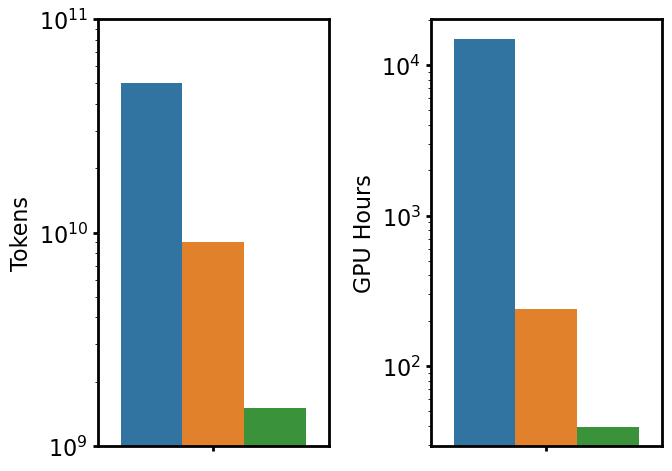

In [21]:
plt.figure(figsize=(7, 5))
plt.subplot(1, 2, 1)
sns.barplot(data=compute_df, y='Tokens', hue='Model', legend=False)
plt.ylim(1e9, 1e11)
plt.yscale('log')

plt.subplot(1, 2, 2)
sns.barplot(data=compute_df, y='GPU Hours', hue='Model', legend=False)
plt.yscale('log')

plt.tight_layout()

### Make figure on rare and test ECs

In [188]:
models = ['ZymCTRL/all_summary_pretrained_temp0.3',
          'ec-onehot-swissprot_20240819-231400/all_summary_ba11000_temp0.3',
          'ec-drfp-swissprot_20240820-004555/all_summary_ba11000_temp0.3',
          'ec-creep-swissprot_20240820-004559/all_summary_ba11000_temp0.3']
names = ['ZymCTRL', 'OH-1.5B', 'DRFP-1.5B', 'CREEP-1.5B']

summary_df = load_models(models, names)
#rename model to Model
summary_df.rename(columns={'model': 'Model'}, inplace=True)
summary_df.reset_index(drop=True, inplace=True)

In [189]:
# train_rare_summary_df = summary_df[summary_df['split'] == 'train_rare_original']

In [190]:
hard_summary_df = summary_df[summary_df['split'].isin(['Train Rare ECs', 'Heldout ECs'])]
test_summary_df = summary_df[summary_df['split'].isin(['Heldout ECs'])]

In [191]:
# #calculate similarity to the common EC classes in the training set (should have been done in generation processing)
# #choose reference ECs to be the most common EC classes
# train_metadata = pd.read_csv('data/CARE_resampled50cluster_medium_withTax/train.csv')
# reference_ECs = train_metadata['EC number'].value_counts()[train_metadata['EC number'].value_counts() > 300].index.tolist()
# #alternatively use all sequences in the train set as references
# #reference_ECs = train_metadata['EC number'].unique().tolist()

# ec2encoding = torch.load('data/ec2drfp.pt')
# # ec2encodings = [torch.load('data/ec2level4_onehot.pt'), torch.load('data/ec2drfp.pt'), torch.load('data/ec2CREEP_text.pt')]


# #subset test_metaata to only unique EC numbers
# unique_test = test_summary_df.drop_duplicates(subset=['ec'])
# unique_test['prediction_similarity'] = unique_test.apply(lambda x: get_average_prediction_similarity(x['ec'], reference_ECs, ec2encoding), axis=1)
# #create dictionary mapping from EC to prediction similarity
# mapping = {row['ec']: row['prediction_similarity'] for i, row in unique_test.iterrows()}
# test_summary_df['Similarity to Train'] = test_summary_df['ec'].map(mapping)

In [192]:
# zymCTRL = pd.DataFrame(columns=test_summary_df.columns)
# #create an empty row
# zymCTRL.loc[0] = np.nan
# zymCTRL['model'] = 'ZymCTRL'
# # zymCTRL[column] = -1
# zymCTRL['Similarity to Train'] = -1
# test_summary_df = pd.concat([test_summary_df, zymCTRL])

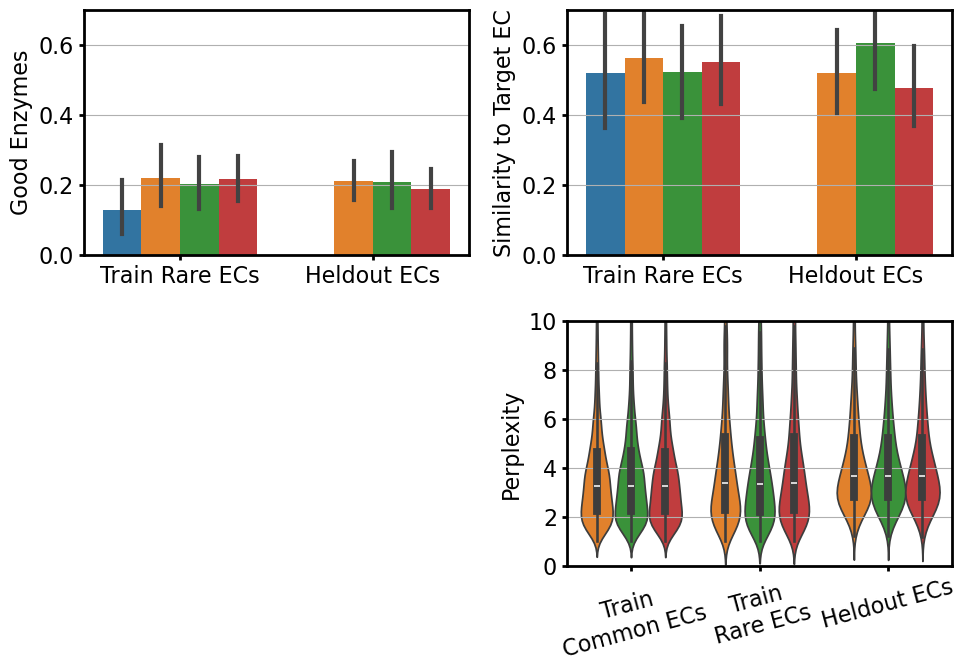

In [195]:
plt.figure(figsize=(10, 7))
i = 0

for column in ["Good Enzymes", "Similarity to Target EC"]:
    i += 1
    plt.subplot(2, 2, i)
    #legend = False if i != 1 else True
    legend = False

    sns.barplot(data=hard_summary_df, x='split', y=column, hue='Model', legend=legend)
    plt.xlabel('')
    #plt.xticks(rotation=10)
    plt.grid(axis='y')
    plt.ylim(0, 0.7)

plt.subplot(2, 2, 4)
sns.violinplot(data=second_perplexity_df, x='split', y='perplexity', hue='model', legend=False, order= ['Train\nCommon ECs', 'Train\nRare ECs', 'Heldout ECs'], palette=sns.color_palette(['tab:orange', 'tab:green', 'tab:red']))
plt.ylim(0, 10)
plt.grid(axis='y')
plt.ylabel('Perplexity')
plt.yticks(np.arange(0, 11, 2))
plt.xticks(rotation=15)
plt.xlabel('')

plt.tight_layout()
plt.savefig('figures/hard.svg', bbox_inches='tight')

/tmp/ipykernel_3374785/705671928.py:6: UserWarning: 
The palette list has fewer values (3) than needed (4) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(data=test_summary_df, x='Similarity to Train', y=column, hue='model', hue_order=['ZymCTRL', 'onehot-1.5B', 'DRFP-1.5B', 'CREEP-1.5B'], legend=False, palette=sns.color_palette(['tab:orange', 'tab:green', 'tab:red']))


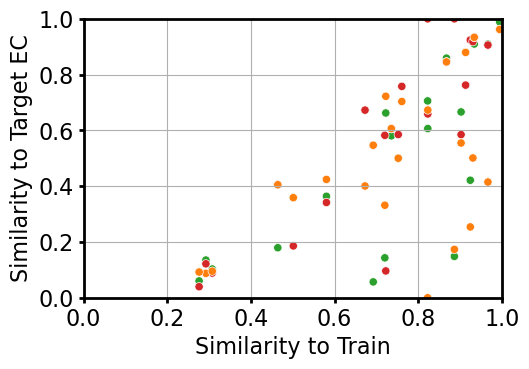

In [180]:
plt.figure(figsize=(10, 7))
for column in ["Similarity to Target EC"]: # "average_accuracy_level"
    i += 1
    plt.subplot(2, 2, 3)
    #filler row in test_summary_df with zymCTRL results
    sns.scatterplot(data=test_summary_df, x='Similarity to Train', y=column, hue='Model', hue_order=['ZymCTRL', 'OH-1.5B', 'DRFP-1.5B', 'CREEP-1.5B'], legend=False, palette=sns.color_palette(['tab:orange', 'tab:green', 'tab:red']))
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.grid(True)
plt.tight_layout()
plt.savefig('figures/similarity_correlation.svg')

In [452]:
#caclulate student t_test for good enzymes
for model in ['OH-1.5B', 'DRFP-1.5B', 'CREEP-1.5B']:
    print(model)
    print(ttest_ind(hard_summary_df[hard_summary_df['model'] == 'ZymCTRL']['Valid Enzymes'], hard_summary_df[hard_summary_df['model'] == model]['Valid Enzymes'], equal_var=False))

onehot-1.5B
TtestResult(statistic=-1.837553397931292, pvalue=0.07368084388774523, df=39.38556698549391)
DRFP-1.5B
TtestResult(statistic=-1.611165739819933, pvalue=0.11440824290970406, df=43.31184885070879)
CREEP-1.5B
TtestResult(statistic=-1.6713358665076687, pvalue=0.10316525233250415, df=36.687754519058345)


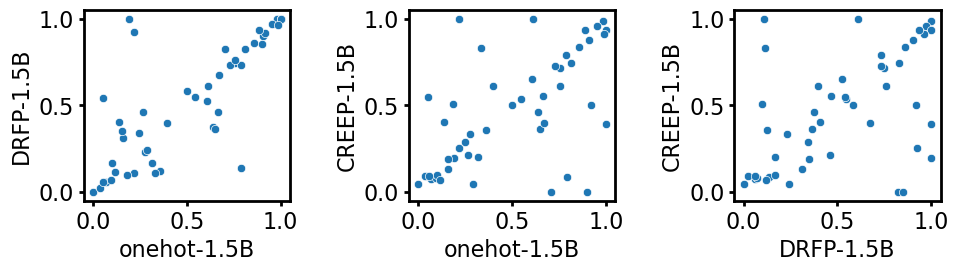

In [478]:
#plot similarity to target EC between each of the three models
plt.figure(figsize=(10, 3))

for i, keep in enumerate([['OH-1.5B', 'DRFP-1.5B'], ['OH-1.5B', 'CREEP-1.5B'], ['DRFP-1.5B', 'CREEP-1.5B']]):
    plt.subplot(1,3,i+1)

    x = hard_summary_df[hard_summary_df['model'] == keep[0]]['Similarity to Target EC'].values
    y = hard_summary_df[hard_summary_df['model'] == keep[1]]['Similarity to Target EC'].values

    sns.scatterplot(x=x, y=y)
    plt.xlabel(keep[0])
    plt.ylabel(keep[1])
plt.tight_layout()

In [107]:
#calculate spearman rho correlation between EC_similarity and average_prediction_similarity for each model
for metric in ['Similarity to Target EC']:
    rho = test_summary_df.groupby('model').apply(lambda x: spearmanr(x['Similarity to Train'], x[metric], nan_policy='omit')[0])
    print(f'{metric}: {rho}')
    

Similarity to Target EC: model
CREEP-1.5B     0.438791
DRFP-1.5B      0.746087
Onehot-1.5B    0.748696
ZymCTRL             NaN
dtype: float64


/tmp/ipykernel_316132/2474741564.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  rho = test_summary_df.groupby('model').apply(lambda x: spearmanr(x['Similarity to Train'], x[metric], nan_policy='omit')[0])


Test set: show correlation between similarity to train set and generated enzymes

### Taxonomy and joint conditioning figure

In [196]:
id2name_dict = {2: 'bacteria', 2157: 'archaea', 10239: 'viruses', 2759: 'eukaryota'}

#pie chart showing the distribution of different EC numbers
train_df = pd.read_csv('../data/CARE_resampled50cluster_medium_withTax/train.csv')
train_df['superkingdom'] = train_df['Tax number'].str.split('.').str[0].astype(int).map(id2name_dict)

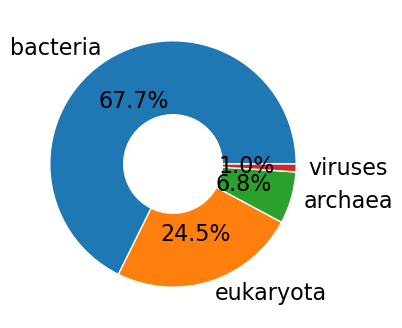

In [197]:
plt.figure(figsize=(4, 4))
plt.pie(train_df['superkingdom'].value_counts(), labels=train_df['superkingdom'].value_counts().index, wedgeprops=dict(width=0.6, edgecolor='w'), autopct='%1.1f%%') #colors=sns.color_palette('Dark2')

plt.savefig('figures/piechart_superkingdom.svg', bbox_inches='tight')

In [198]:
models = ['tax-swissprot_20240820-004651/all_summary_ba21000_temp0.3',
          'tax-swissprot_20240820-004651/all_summary_ba63000_temp0.3',
          'ec+tax-swissprot_20240819-231401/all_summary_ba21000_temp0.3',
          'ec+tax-swissprot_20240819-231401/all_summary_ba63000_temp0.3',
          'ec+tax-swissprot-shared_20240822-232820/all_summary_ba21000_temp0.3']
names = ['Tax-3B',  'Tax-9B', 'Joint-3B', 'Joint-9B', 'Joint-Shared-3B'] #'Onehot-3B', 'DRFP-3B', 'CREEP-3B',
# models = models[:4]
# names = names[:4]

summary_df = load_models(models, names)
summary_df = summary_df.reset_index(drop=True)
summary_df['kingdom'] = summary_df['tax'].apply(lambda x: int(x.split('.')[0])).map(id2name_dict)
summary_df = summary_df.rename(columns={'model': 'Model'})

subset_summary_df = summary_df[summary_df['Model'].isin(['Tax-9B', 'Joint-9B'])]
#rename to Tax and Joint
mapping = {'Tax-9B': 'Tax', 'Joint-9B': 'Joint'}
subset_summary_df['Model'] = subset_summary_df['Model'].map(mapping)

other_summary_df = summary_df[summary_df['Model'].isin(['Tax-3B', 'Joint-3B', 'Joint-Shared-3B'])]

/tmp/ipykernel_3374785/3988843881.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_summary_df['Model'] = subset_summary_df['Model'].map(mapping)


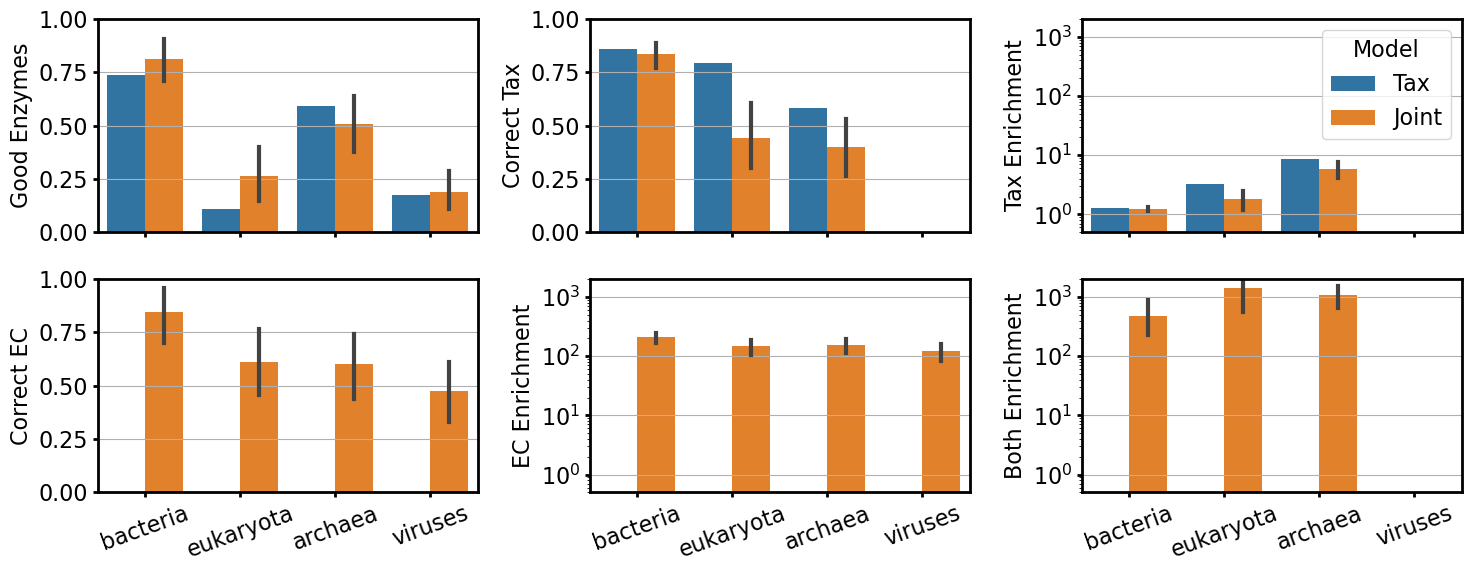

In [202]:
#performance of taxonomy conditioning
plt.figure(figsize=(15, 6))
i = 0
for j, column in enumerate(["Valid Enzymes", "Correct Tax", "Tax Enrichment", "Correct EC", "EC Enrichment", "Both Enrichment"]):
    i += 1
    legend = False if i != 3 else True
    plt.subplot(2, 3, i)

    sns.barplot(data=subset_summary_df, x='kingdom', y=column, hue='Model', legend=legend,  order=['bacteria', 'eukaryota', 'archaea', 'viruses']) #hue_order=['bacteria', 'eukaryota', 'archaea', 'viruses'] #palette=sns.color_palette(['tab:orange', 'tab:green', 'tab:red'])

    if "Enrichment" in column:
        plt.yscale('log')
        plt.ylim(0.5, 2e3)
    else:
        plt.ylim(0, 1)
    
    if i <=3:
        ax = plt.gca()
        ax.set_xticklabels([])
        
    plt.xticks(rotation=20)
    plt.xlabel('')
    plt.grid(axis='y')

plt.tight_layout()
plt.savefig('figures/taxonomy.svg', bbox_inches='tight')

### Ablation study on whether training for less or the shared model works as well here

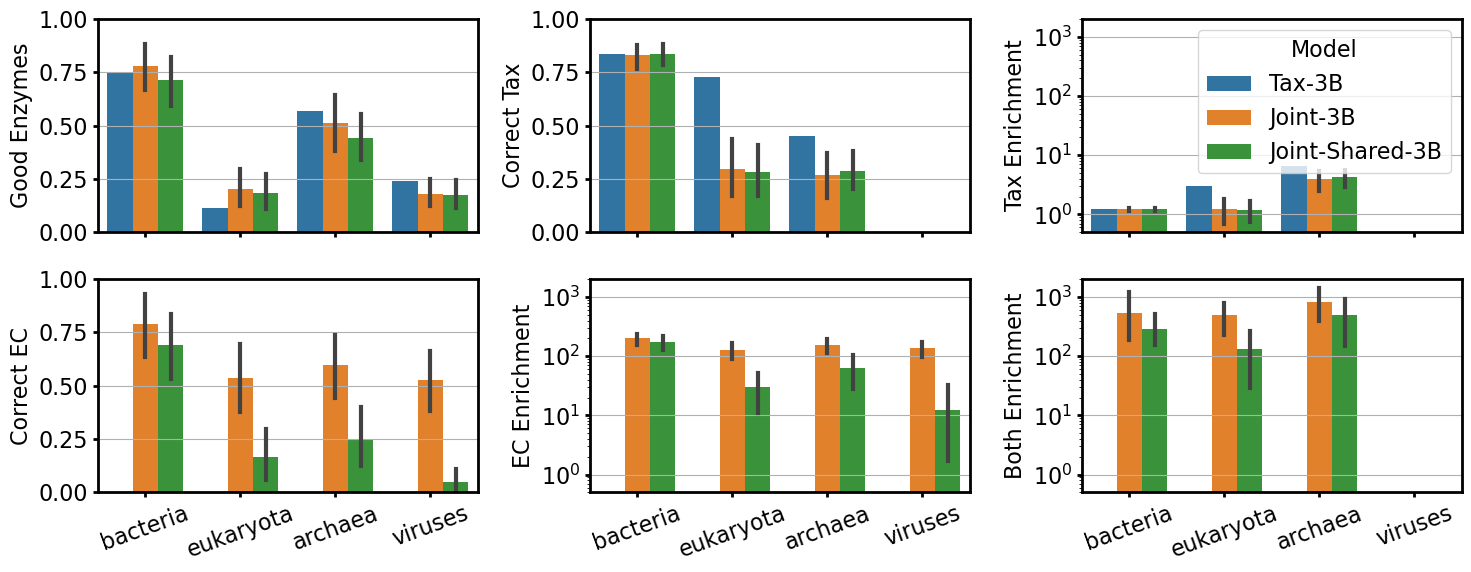

In [201]:
#performance of taxonomy conditioning
plt.figure(figsize=(15, 6))
i = 0
for j, column in enumerate(["Valid Enzymes", "Correct Tax", "Tax Enrichment", "Correct EC", "EC Enrichment", "Both Enrichment"]):
    i += 1
    legend = False if i != 3 else True
    plt.subplot(2, 3, i)

    sns.barplot(data=other_summary_df, x='kingdom', y=column, hue='Model', legend=legend,  order=['bacteria', 'eukaryota', 'archaea', 'viruses']) #hue_order=['bacteria', 'eukaryota', 'archaea', 'viruses'] #palette=sns.color_palette(['tab:orange', 'tab:green', 'tab:red'])

    if "Enrichment" in column:
        plt.yscale('log')
        plt.ylim(0.5, 2e3)
    else:
        plt.ylim(0, 1)
    
    if i <=3:
        ax = plt.gca()
        ax.set_xticklabels([])
        
    plt.xticks(rotation=20)
    plt.xlabel('')
    plt.grid(axis='y')

plt.tight_layout()
plt.savefig('figures/taxonomy_ablation.svg', bbox_inches='tight')

In [211]:
# #performance of taxonomy conditioning
# plt.figure(figsize=(8, 6))
# i = 0
# for j, columns in enumerate([["Valid Enzymes", "Correct Tax", "Correct EC"], ["Tax Enrichment", "EC Enrichment", "Both Enrichment"]]):
#     for summary_df in [tax_summary_df, joint_summary_df]:
#         i += 1
#         legend = False if i != 3 else True
#         plt.subplot(2, 2, i)

#         df = pd.DataFrame(columns=['value', 'label', 'kingdom'])
#         for k, row in summary_df.iterrows():
#             for col in columns:
#                 df.loc[len(df.index)] = [row[col], col, row['kingdom']]

#         sns.barplot(data=df, x='label', y='value', hue='kingdom', hue_order=['bacteria', 'eukaryota', 'archaea',  'viruses'], legend=legend)
#         if j == 1:
#             plt.yscale('log')
#             plt.ylim(0.5, 2e3)
#         else:
#             plt.ylim(0, 1)
#         plt.ylabel('')
#         plt.xticks(rotation=15)
#         plt.xlabel('')
#         plt.grid(axis='y')

# plt.tight_layout()

## Out of distibution (low bacteria) results

In [2]:
models = ['ec+tax-swissprot-lowbacteria_20240824-202511/all_summary_ba11000_temp0.3', 
          'ec+tax-swissprot-shared-lowbacteria_20240824-202720/all_summary_ba11000_temp0.3',
          'ec+tax-swissprot_20240819-231401/all_summary_ba21000_temp0.3']
names = ['Joint-1.5B', 'Joint-shared-1.5B', 'Joint-NoHeldout-1.5B'] #

with open('../data/ECs_generation/low_bacteria_common_ecs.txt') as f:
    low_bacteria_ecs = f.read().splitlines()

id2name_dict = {2: 'bacteria', 2157: 'archaea', 10239: 'viruses', 2759: 'eukaryota'}
summary_df = load_models(models, names)
summary_df = summary_df[summary_df['ec'].isin(low_bacteria_ecs)]
summary_df = summary_df.reset_index(drop=True)
summary_df['kingdom'] = summary_df['tax'].apply(lambda x: int(x.split('.')[0])).map(id2name_dict)
summary_df['Conditioning'] = summary_df['kingdom'] == 'bacteria'
summary_df['Combined Fraction'] = summary_df['Valid Enzymes'] * summary_df['Both Correct']
#replace True with 'bacteria' and False with 'other'
summary_df['Conditioning'] = summary_df['Conditioning'].replace({True: 'bacteria', False: 'other taxa'})

summary_df = summary_df.rename(columns={'model': 'Model'})

bacteria_summary_df = summary_df[summary_df['kingdom'] == 'bacteria']
single_model_summary_df = summary_df[summary_df['Model'] == 'Joint-1.5B']
single_model_bacteria_summary_df = single_model_summary_df[single_model_summary_df['kingdom'] == 'bacteria']

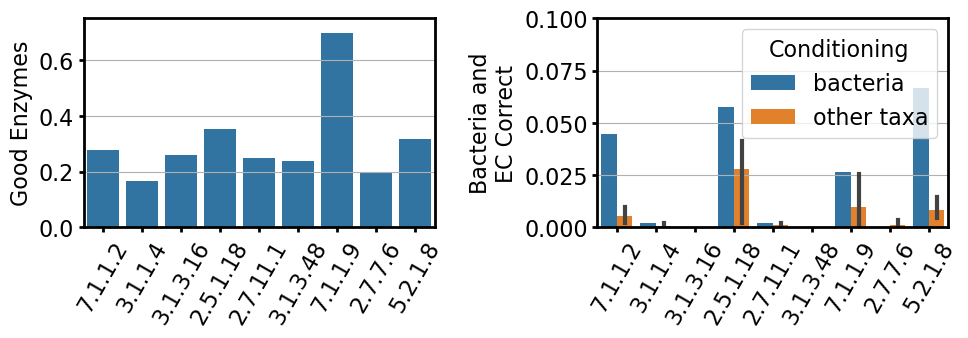

In [3]:
#performance of taxonomy conditioning
plt.figure(figsize=(15, 6))
i = 0
for j, column in enumerate(["Valid Enzymes", "Combined Fraction"]): #"Both Correct"]
    i += 1
    legend = False if i != 2 else True
    plt.subplot(2, 3, i)
    
    if i == 1:
        sns.barplot(data=single_model_bacteria_summary_df, x='ec', y=column, legend=legend)
    else:
        sns.barplot(data=single_model_summary_df, x='ec', y=column, hue='Conditioning', legend=legend, hue_order=['bacteria', 'other taxa']) #hue_order=['bacteria', 'eukaryota', 'archaea', 'viruses'] #palette=sns.color_palette(['tab:orange', 'tab:green', 'tab:red'])

    if i == 2:
        plt.ylim(0, 0.1)
        plt.ylabel('Bacteria and\nEC Correct')
    else:
        plt.ylim(0, 0.75)
        
    plt.xticks(rotation=60)
    plt.xlabel('')
    plt.grid(axis='y')

plt.tight_layout()
plt.savefig('figures/lowbacteria.svg', bbox_inches='tight')

Abalation study on whether the shared model works for this task

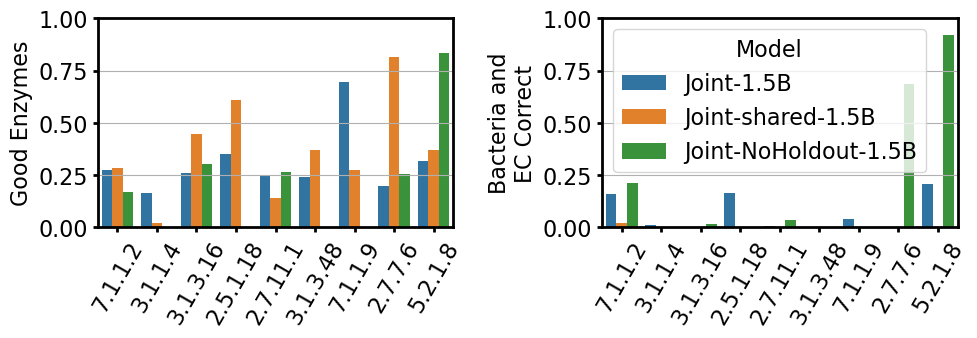

In [150]:
#performance of taxonomy conditioning
plt.figure(figsize=(15, 6))
i = 0
for j, column in enumerate(["Valid Enzymes", "Both Correct"]):
    i += 1
    legend = False if i != 2 else True
    plt.subplot(2, 3, i)

    sns.barplot(data=bacteria_summary_df, x='ec', y=column, hue='Model', legend=legend) #hue_order=['bacteria', 'eukaryota', 'archaea', 'viruses'] #palette=sns.color_palette(['tab:orange', 'tab:green', 'tab:red'])
    if column == 'Both Correct':
        plt.ylabel('Bacteria and\nEC Correct')

    if "Enrichment" in column:
        plt.yscale('log')
        plt.ylim(0.5, 2e3)
    else:
        plt.ylim(0, 1)
        
    plt.xticks(rotation=60)
    plt.xlabel('')
    plt.grid(axis='y')

plt.tight_layout()
#plt.savefig('figures/taxonomy.svg', bbox_inches='tight')

### compare swissprot onehot with a smaller model and a summed model (ablation study)

In [212]:
#load perplexities
models = ['ec-onehot-swissprot_20240819-231400/perplexity_ba11000',
          'ec-onehot-swissprot-small_20240822-232820/perplexity_ba11000',
          'ec-onehot-swissprot-summed_20240822-232823/perplexity_ba11000']
names = ['Swissprot-1.5B', 'Small-1.5B', 'Summed-1.5B']

dfs = []
# perplexity_df = load_models(models, names)
#sns.violinplot(data=df, x='split', y='perplexity', cut=0, density_norm="width") #hue='model'

for model, name in zip(models, names):
    perplexity_df = pd.read_csv(f'../results/{model}.csv')
    perplexity_df['model'] = name
    dfs.append(perplexity_df)

perplexity_df = pd.concat(dfs)
mapping = {'train_common': 'Train\nCommon ECs', 'train_rare': 'Train\nRare ECs', 'test': 'Heldout ECs', 'val70': 'Heldout 70%', 'val90': 'Heldout 90%'}
perplexity_df['split'] = perplexity_df['split'].map(mapping)
perplexity_df.reset_index(drop=True, inplace=True)

#first_perplexity_df = perplexity_df[perplexity_df['split'].isin(['Train\nCommon ECs', 'Heldout 70%', 'Heldout 90%'])] #'Uniref-OH-1.5B'
# second_perplexity_df = perplexity_df[perplexity_df['split'].isin(['Train\nCommon ECs', 'Train\nRare ECs', 'Heldout ECs']) & perplexity_df['model'].isin(['Swissprot-OH-1.5B', 'Swissprot-DRFP-1.5B', 'Swissprot-CREEP-1.5B'])]

In [213]:
models = [model.split('/')[0] + '/all_summary_ba11000_temp0.3' for model in models]

summary_df = load_models(models, names)
summary_df.rename(columns={'model': 'Model'}, inplace=True)
summary_df = summary_df.reset_index(drop=True)
train_common_summary_df = summary_df[summary_df['split'] == 'Train Common ECs']
train_common_summary_df

,Model,checkpoint,ec,tax,split,n_generated,frac_terminated,Good Proteins,n_good,Frac Enzymes,...,Mean Max \nSeq Identity,70% Clusters,90% Clusters,generated_ECs,both_count,ec_count,tax_count,Similarity to Target EC,Similarity to Train,Good Enzymes
0,Swissprot-1.5B,ba11000,2.7.1.148,no-tax,Train Common ECs,900,0.750000,0.741111,667,1.000000,...,0.630233,0.136432,0.961019,"['2.7.1.148', '2.7.1.148', '2.7.1.148', '2.7.1...",NaN,514,NaN,1.0,1.0,0.741111
1,Swissprot-1.5B,ba11000,2.7.13.3,no-tax,Train Common ECs,900,0.552222,0.203333,183,0.546448,...,0.478147,0.800000,1.000000,"['2.7.13.3', '1.14.14.1', '2.7.13.3', '2.7.13....",NaN,579,NaN,1.0,1.0,0.111111
2,Swissprot-1.5B,ba11000,6.1.1.15,no-tax,Train Common ECs,900,0.991111,0.983333,885,0.998870,...,0.834278,0.015837,0.214932,"['6.1.1.15', '6.1.1.15', '6.1.1.15', '6.1.1.15...",NaN,525,NaN,1.0,1.0,0.982222
3,Swissprot-1.5B,ba11000,1.2.1.70,no-tax,Train Common ECs,900,0.636667,0.595556,536,0.996269,...,0.784895,0.039326,0.588015,"['1.2.1.70', '1.2.1.70', '1.2.1.70', '1.2.1.70...",NaN,561,NaN,1.0,1.0,0.593333
4,Swissprot-1.5B,ba11000,2.5.1.75,no-tax,Train Common ECs,900,0.981111,0.976667,879,0.997725,...,0.609452,0.071836,0.995439,"['2.5.1.75', '2.5.1.75', '2.5.1.75', '2.5.1.75...",NaN,648,NaN,1.0,1.0,0.974444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,Summed-1.5B,ba11000,2.7.7.6,no-tax,Train Common ECs,900,0.583333,0.416667,375,0.832000,...,0.694212,0.471154,0.753205,"['2.7.1.40', '2.7.7.6', '2.7.7.6', '2.7.1.40',...",NaN,894,NaN,1.0,1.0,0.346667
164,Summed-1.5B,ba11000,3.1.1.29,no-tax,Train Common ECs,900,0.980000,0.975556,878,0.998861,...,0.672434,0.013683,0.706956,"['3.1.1.29', '3.1.1.29', '3.1.1.29', '3.1.1.29...",NaN,553,NaN,1.0,1.0,0.974444
165,Summed-1.5B,ba11000,6.1.1.21,no-tax,Train Common ECs,900,0.905556,0.808889,728,0.968407,...,0.757821,0.153191,0.462411,"['6.1.1.21', '6.1.1.21', '6.1.1.21', '6.1.1.21...",NaN,516,NaN,1.0,1.0,0.783333
166,Summed-1.5B,ba11000,2.7.1.33,no-tax,Train Common ECs,900,0.926667,0.912222,821,0.998782,...,0.627473,0.196341,0.880488,"['2.7.1.33', '2.7.1.33', '2.7.1.33', '2.7.1.33...",NaN,543,NaN,1.0,1.0,0.911111


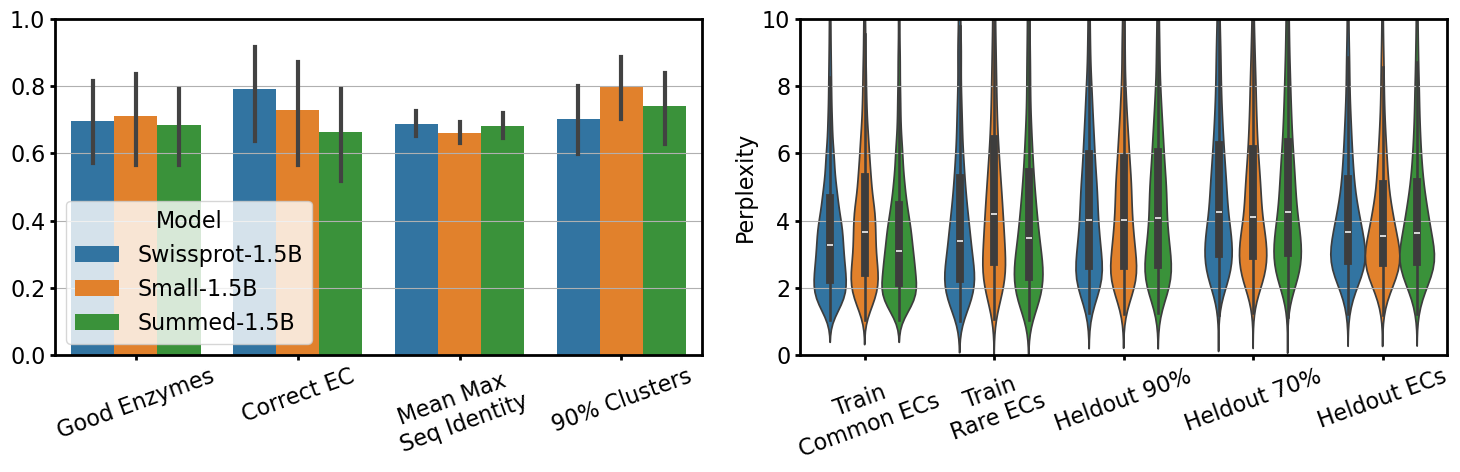

In [217]:
plt.figure(figsize=(15, 5)) #a bit narrow for full width
i = 0

for columns in [["Valid Enzymes", "Correct EC", "Mean Max \nSeq Identity", "90% Clusters"]]:
    i += 1
    plt.subplot(1, 2, i)
    legend = True if i == 1 else False

    df = pd.DataFrame(columns=['value', 'label', 'Model'])

    for j, row in train_common_summary_df.iterrows():
        for col in columns:
            df.loc[len(df.index)] = [row[col], col, row['Model']]

    sns.barplot(data=df, x='label', y='value', hue='Model', legend=legend)
    plt.ylabel('')
    plt.xticks(rotation=20)
    plt.xlabel('')
    plt.ylim(0, 1)
    plt.grid(axis='y')
    if i == 2:
        plt.gca().set_yticklabels([])

plt.subplot(1, 2, 2)
sns.violinplot(data=perplexity_df, x='split', y='perplexity', hue='model', legend=False, order=['Train\nCommon ECs', 'Train\nRare ECs', 'Heldout 90%', 'Heldout 70%', 'Heldout ECs'])
plt.xticks(rotation=20)
plt.ylim(0, 10)
plt.ylabel('Perplexity')
plt.xlabel('')
plt.grid(axis='y')

plt.tight_layout()
plt.savefig('figures/architecture_ablation.svg', bbox_inches='tight')

## Loss curves for full finetuning vs normal

In [168]:
models = ['ec-onehot-swissprot_20240819-231400/metrics', 'ec-onehot-swissprot-ff_20240822-163730/metrics']
names = ['Parameter Efficient', 'Full Finetuning']

mapping = {'metrics/val70/loss/ar_lm_perplexity': 'Heldout 70%', 'metrics/val90/loss/ar_lm_perplexity': 'Heldout 90%', 'metrics/test/loss/ar_lm_perplexity': 'Heldout ECs', 'metrics/train/loss/ar_lm_perplexity': 'Train'}
batch_size = 144e3

dfs = []
for model, name in zip(models, names):
    summary_df = pd.read_csv(f'../results/{model}.csv')
    summary_df['Model'] = name
    dfs.append(summary_df)
summary_df = pd.concat(dfs)

summary_df['Split'] = summary_df['key'].map(mapping)
#round down to nearest 100
summary_df['window'] = summary_df['step'].apply(lambda x: (x // 100) * 100)
#drop run_id, key, and timestamp columns
summary_df.drop(columns=['run_id', 'key', 'timestamp'], inplace=True)
#group value column by mean and fix the other columns
summary_df = summary_df.groupby(['Model', 'Split', 'window']).mean().reset_index()
summary_df['loss'] = np.log(summary_df['value'])

summary_df['Tokens'] = summary_df['window'] * batch_size

#calculate the rolling mean of value based on 100 steps
#only do it for split = Train
# summary_df['value'] = summary_df['value'].rolling(100).mean()

#for chunks of 100 steps, take the average


summary_df.reset_index(drop=True, inplace=True)

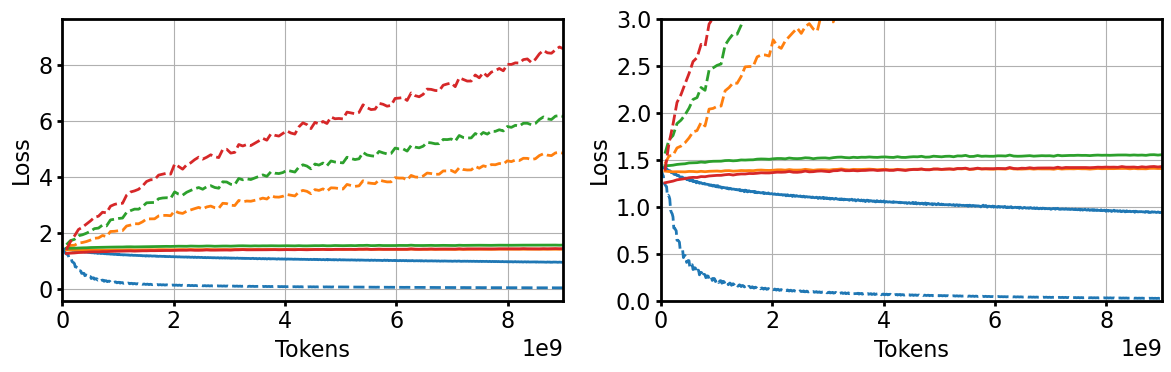

In [172]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
sns.lineplot(data=summary_df, x='Tokens', y='loss', hue='Split', style='Model', legend=False, hue_order=['Train', 'Heldout 90%', 'Heldout 70%', 'Heldout ECs'], style_order=['Parameter Efficient', 'Full Finetuning'])
plt.xlim(0, 9e9)
#make log y scale
#plt.yscale('log')
plt.ylabel('Loss')
plt.grid()

plt.subplot(1, 2, 2)
sns.lineplot(data=summary_df, x='Tokens', y='loss', hue='Split', style='Model', legend=False, hue_order=['Train', 'Heldout 90%', 'Heldout 70%', 'Heldout ECs'], style_order=['Parameter Efficient', 'Full Finetuning'])
plt.xlim(0, 9e9)
plt.ylim(0, 3)
plt.ylabel('Loss')
plt.grid()

plt.tight_layout()
plt.savefig('figures/loss_curves.svg', bbox_inches='tight')